# Compute the Leaf Node current use

This notebook shows how the wake-cycle current use was computed for the leaf node.

To compute the current, an oscilloscpe was used to measure the voltage across a 2.2ohm resistor connected between the leaf node circuit ground and the power supply ground. The circuit was sampled and when a positive voltage read the data were stored for a 14 second time window. The sampling rate was 200kHz.

James Gallagher <jgallagher@opendap.org>  9/5/21

In [1]:
import numpy as np
from scipy.signal import butter, sosfilt

# plotly makes nice plots, but the don't render in Github
# and require a runtime engine that sometimes quits.
#
# import plotly.graph_objects as go
# import plotly.express as px

# use matploylib since the figures render in Github
import matplotlib.pyplot as plt

# Add ipympl for the jupyter notebook 'magic' (https://github.com/matplotlib/ipympl)
# conda install ipympl -c conda-forge

### The raw data from the oscilloscpe
![The raw data from the oscilloscpe](Current_measurement/LN_Current_13dBm_23dBm/23dBm.png)
    

## Process the data

Read the data from the Siglent scope's csv file into a numpy array. The data are two columns, time and then voltage. Extract the voltages from the 2D array so they can be filtered.

See https://numpy.org/doc/stable/reference/generated/numpy.genfromtxt.html for information about numpy genfromtxt() which reads data from CSV files.

See https://www.tutorialspoint.com/numpy/numpy_indexing_and_slicing.htm for information about numpy slicing, which is used in several cells.

In [2]:
# For the tests where the LoRa was transmitting at 13dBm
# data_file = 'Current_measurement/LN_Current_13dBm_23dBm/13dBm_current.csv'

# For the tests where the LoRa was transmitting at 23dBm
data_file = 'Current_measurement/LN_Current_13dBm_23dBm/23dBm_current.csv'
header_lines = 12
data = np.genfromtxt(data_file, delimiter=',', skip_header=header_lines)

# slice so we have only the voltage values. 'data_file' holds both the sample time
# and the voltage as CSV data.
offset = 0.0
voltages = data[..., 1] + offset    # * 1000 / args.resistance


Define a low-pass filter using the SciPy package

In [3]:
def butter_lowpass_filter(data, cutoff, fs, order):
    """
    @param data The data to be filtered
    @param cutoff The cutoff frequency in Hz
    @param fs The sampling frequency
    @param order The order of the filter
    """
    nyq = 0.5 * fs  # Nyquist Frequency
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients - second order sections
    sos = butter(order, normal_cutoff, btype='low', analog=False, output='sos')
    y = sosfilt(sos, data)
    return y


Now filter the voltages to remove the noise, then threshold the filtered values so that anything below some arbitrary value becomes zero. From the raw and filtered/thresholded voltages, compute the current.

See https://stackoverflow.com/questions/12424824/how-i-can-i-conditionally-change-the-values-in-a-numpy-array-taking-into-account for information about the numpy relational op used to threshold the filtered_volts[] array.

In [4]:
# Filter requirements.

fs = 200000.0  # sample rate, Hz
cutoff = 1000.0  # desired cutoff frequency of the filter, Hz
order = 4 # I chose a fourth-order filter by experiment. Higher did not produce a better result.

filtered_volts = butter_lowpass_filter(voltages, cutoff, fs, order)

# Threshold post filtering.
# y is derived from 'data' which is a numpy array, so this works to set
# all the values of 'y' less than threshold_value to 0.0.
threshold_value = 0.00015
filtered_volts[filtered_volts < threshold_value] = 0.0

resistance = 2.2 # ohms
# multiply the current (A) by 1000 to get mA which makes for a better plot
mA = voltages / resistance * 1000.0
filtered_mA = filtered_volts / resistance * 1000.0

## Plot the data
Now plot the filtered data.

<Figure size 640x480 with 0 Axes>

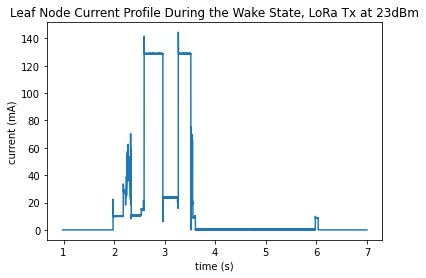

In [17]:
# Turn off the interactive mode for the notebook
# %matplotlib widget

fig, ax = plt.subplots()  # Create a figure containing a single axes.

# x=data[::100, 0] Time
# y=filtered_mA[::100] Current

ax.plot(data[::100, 0], filtered_mA[::100])
ax.set_title("Leaf Node Current Profile During the Wake State, LoRa Tx at 23dBm")
ax.set_xlabel("time (s)")
ax.set_ylabel("current (mA)")

plt.draw()

Compare the filtered and raw current data.

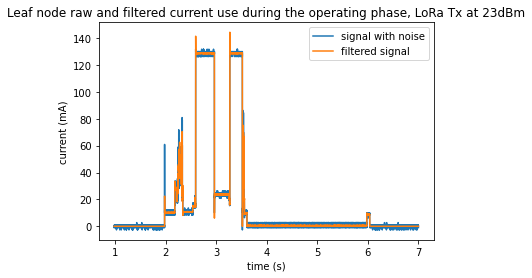

In [6]:
# %matplotlib widget

fig, ax = plt.subplots()  # Create a figure containing a single axes.

# x=data[::100, 0] Time
# y=filtered_mA[::100] Current

ax.plot(data[::100, 0], mA[::100], label='signal with noise')
ax.plot(data[::100, 0], filtered_mA[::100], label='filtered signal')
ax.set_title("Leaf node raw and filtered current use during the operating phase, LoRa Tx at 23dBm")
ax.set_xlabel("time (s)")
ax.set_ylabel("current (mA)")
ax.legend()

plt.draw()


## Compute the runtime
Now that the current data looks good, compute the average current use for the wake-cycle time (which looks like about 4s - also compute the exact time).

In [7]:
def calc_values_from_filtered_data(data, zero_value, delta_t, resistance):
    """
    @param data is corrected voltage for a time slice
    @param zero_value is the value to call 'zero volts' FIXME Remove
    @param delta_t is the duration of each sample
    @param resistance Used to convert mV to mA
    """
    volts_samples = 0.0
    samples = 0
    start_time = 0.0
    end_time = 0.0
    sample = 0

    for volts in data:
        if volts > zero_value:
            if start_time == 0.0:
                start_time = sample * delta_t
            end_time = sample
            samples += 1         # count the samples, divide once outside of loop
            volts_samples += volts     # As above, factor out '* delta_t'
        sample += 1

    # Complete calculations and print the results
    end_time *= delta_t
    total_time = samples * delta_t
    # volts_samples / samples: average voltage/sample; * delta_t is avg voltage/second
    # delta_t is seconds/sample --> avg voltage / sample * delta_t is voltage/second
    # voltage/second / resistance is  Amps/ econd; * 1000 --> mA/s
    # mA/s * total_time is mAs
    mAs = (volts_samples / samples) / resistance * 1000

    print(f"Sample start time: {start_time:.2f}s, end time: {end_time:.2f}s, total time awake: {total_time:.2f}s, mAs: {mAs:.0f}\n")



Calculate the total time the node was awake using the number of samples that were above the zero threshold and multiplying by the duration of a sample.

In [8]:
dx = 0.000005 # Sample duration in seconds

# The values for these parameters are set in cells above, including the graphing cells.
# The values are:
print(f"Threshold value: {threshold_value}V")
print(f"Delta X: {dx}s")
print(f"Resistance: {resistance}ohms")

calc_values_from_filtered_data(filtered_volts, threshold_value, dx, resistance)

Threshold value: 0.00015V
Delta X: 5e-06s
Resistance: 2.2ohms
Sample start time: 1.00s, end time: 5.06s, total time awake: 4.04s, mAs: 25



Battry life calculation

The Leaf node has 2 2,400mAh batteries in parallel, providing 4,800mAh of charge.

The duty cycle of the LN is 3600s, ~4s on (25mA) and 3596s sleeping (18.5µA)

In [9]:
mA_duty_cycle = (25.0 * 4 + 18.5 * 0.000001 * 3596.0) / 3600.0

In [10]:
battery_life = 4800.0 / mA_duty_cycle

hours_per_year = 365 * 24

print(f"Battery life: {battery_life:.0f}h, or {battery_life / hours_per_year:.1f} years")

Battery life: 172685h, or 19.7 years
